In [3]:
%load_ext autoreload
%autoreload 2

# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics (correlation)
from scipy.stats import pearsonr, spearmanr

# libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score

In [39]:
# custom functions
from pt_helpers import *

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [5]:
data_path = "DATA/training_data/"

df = pd.read_csv(data_path + "VEX_edac_mag_labeled.csv")

In [6]:
df.head()

,DATE_TIME,EDAC,BX,BY,BZ,BT,XSC,YSC,ZSC,RSC,cme
0,2006-04-24 00:00:00,0,12.357658,-1.304164,-3.332425,12.881274,-4451.055178,-3196.485753,-65466.762260,65695.760575,0
1,2006-04-24 00:05:00,0,12.868947,-0.980800,-3.360027,13.340680,-4202.246280,-3138.377907,-65806.350827,66015.078600,0
2,2006-04-24 00:10:00,0,12.857438,-0.871986,-3.487877,13.355384,-3954.000329,-3080.233288,-66137.913808,66327.612616,0
3,2006-04-24 00:15:00,0,12.898635,-0.684986,-2.885689,13.248405,-3705.057257,-3021.761270,-66463.291041,66635.079608,0
4,2006-04-24 00:20:00,0,12.766473,-0.517608,-2.217135,12.972905,-3453.676541,-2962.553108,-66784.717784,66939.596338,0


We separate the feature matrix `X` and the labels `y`.
- `X` will contain X Y and Z coordinates of the magnetic field

In [7]:
y = df['cme'].values
X = df[['BX', 'BY', 'BZ']].values

In [8]:
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)

Shape of y: (893069,)
Shape of X: (893069, 3)


## LSTM

In [9]:
time_steps = 36  # 3 hours of data
X_seq, y_seq = create_sequences(X, y, time_steps)

In [16]:
class CMEPredictor(nn.Module):
    def __init__(self, n_features, n_hidden=50, n_layers=2):
        super(CMEPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return torch.sigmoid(x)

n_features = X_seq.shape[2]  # Number of features in the dataset
model = CMEPredictor(n_features)

In [25]:
X_seq.shape

(893033, 36, 3)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

In [18]:
# Create DataLoaders
batch_size = 32  # Adjust this based on your system's capability
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

### Training and evaluation

In [20]:
# Training loop with reduced batch size and data loading on-the-fly
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            val_output = model(X_batch)
            val_loss += criterion(val_output, y_batch.view(-1, 1)).item()
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss}')

Epoch 1, Loss: 0.027205409482121468, Val Loss: 0.05169392659492218
Epoch 2, Loss: 0.01583762839436531, Val Loss: 0.044151000564042656
Epoch 3, Loss: 0.0022829226218163967, Val Loss: 0.03417239301476847
Epoch 4, Loss: 0.020978279411792755, Val Loss: 0.028188733547968577
Epoch 5, Loss: 0.0016961646033450961, Val Loss: 0.02534894986760983
Epoch 6, Loss: 0.0021002606954425573, Val Loss: 0.020588622067348433
Epoch 7, Loss: 0.0007419955218210816, Val Loss: 0.01946681995389429
Epoch 8, Loss: 0.0033761681988835335, Val Loss: 0.017162688995538078
Epoch 9, Loss: 0.00022286208695732057, Val Loss: 0.013975792310095582
Epoch 10, Loss: 0.0004701327416114509, Val Loss: 0.011868051151635613


In [21]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold for binary classification
        predictions.extend(predicted.view(-1).tolist())
        true_labels.extend(y_batch.tolist())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.9960415885155677
F1 Score: 0.8830438378825476
Precision: 0.9146675805346127
Recall: 0.8535337384074193


## LSTM with class weights

In [22]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Use the class weights in your loss function
criterion = nn.BCELoss(weight=class_weights[1])  

In [23]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()

        # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, y_batch in val_loader:
            val_output = model(X_batch)
            val_loss += criterion(val_output, y_batch.view(-1, 1)).item()
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss}')

Epoch 1, Loss: 0.016685394570231438, Val Loss: 0.31954262459213756
Epoch 2, Loss: 0.01373108197003603, Val Loss: 0.27624625025029853
Epoch 3, Loss: 0.02301291562616825, Val Loss: 0.2396752243539735
Epoch 4, Loss: 0.12997180223464966, Val Loss: 0.28266959688653237
Epoch 5, Loss: 0.0013374778209254146, Val Loss: 0.23060823440533634
Epoch 6, Loss: 0.4464322328567505, Val Loss: 0.2102536807217629
Epoch 7, Loss: 0.00554665457457304, Val Loss: 0.19836650296054145
Epoch 8, Loss: 0.7542791962623596, Val Loss: 0.22506573631425825
Epoch 9, Loss: 0.03719411790370941, Val Loss: 0.23387905123019448
Epoch 10, Loss: 0.051757436245679855, Val Loss: 0.18090363184466993


In [24]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold for binary classification
        predictions.extend(predicted.view(-1).tolist())
        true_labels.extend(y_batch.tolist())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.997990000391922
F1 Score: 0.9415214204267797
Precision: 0.9594953519256308
Recall: 0.9242085065558043


## Interpreting the model

Since this last model is good (99.7% accuracy and 94% F1 score), we will now interpret the model to understand what it has learned to predict. 

More specifically, we will search the input (timeseries of X, Y and Z coordinates during 3 hours) that maximises the logit of class 1. In other words, which pattern of the magnetic field is the most likely to be linked with a CME event according to our model?

We will also look at the pattern which minimizes the logits of class 1 (i.e. which pattern of the magnetic field is the less likely to be linked with a CME event according to our model)

In [78]:
# Input maximizing the logit for class 1
model.eval()

# Initialize an input tensor with random data
input_tensor = torch.zeros((1, 36, 3), requires_grad=True)
optimizer = torch.optim.SGD([input_tensor], lr=1)

# Want to maximize the logit for class 1, so we can use gradient ascent:
for i in range(1000):  # Run for a number of iterations
    optimizer.zero_grad()
    logits = model(input_tensor)
    
    # We look at logits for class 1
    target_logit = logits.squeeze()
    
    # Maximize the logit (PyTorch minimizes by default, so we negate to maximize)
    loss = -target_logit
    loss.backward()
    optimizer.step()

# Detach the input_tensor from the graph and turn off gradients
optimized_input = input_tensor.detach().cpu().numpy()

In [79]:
# Input minimizing the logit for class 1
model.eval()

# Initialize an input tensor with random data
input_tensor = torch.zeros((1, 36, 3), requires_grad=True)
optimizer = torch.optim.SGD([input_tensor], lr=1)

# We want to minimize the logit for class 1, using gradient descent
for i in range(1000):
    optimizer.zero_grad()
    logits = model(input_tensor)
    target_logit = logits.squeeze()

    loss = target_logit
    loss.backward()
    optimizer.step()

minimized_input = input_tensor.detach().cpu().numpy()

In [82]:
# import torch.nn.functional as F

# Assuming the model has been defined, trained, and is available in your environment
# Also assuming optimized_input and minimized_input are available as tensors

# Set the model to evaluation mode
model.eval()

# Wrap the inputs in a tensor, if they are not already. No gradient needed for prediction.
optimized_input_tensor = torch.tensor(optimized_input, dtype=torch.float32)
minimized_input_tensor = torch.tensor(minimized_input, dtype=torch.float32)

# Perform a forward pass to get the logits
optimized_logits = model(optimized_input_tensor)
minimized_logits = model(minimized_input_tensor)

print(f"Logit for optimized input: {optimized_logits.item()}")
print(f"Logit for minimized input: {minimized_logits.item()}")

# Apply sigmoid to convert logits to probabilities
optimized_probabilities = torch.sigmoid(optimized_logits)
minimized_probabilities = torch.sigmoid(minimized_logits)

# Print the predictions
# The probability of class 1 (CME event) is the value itself for binary classification
print(f"Prediction for optimized input (probability of CME): {optimized_probabilities.item()}")
print(f"Prediction for minimized input (probability of CME): {minimized_probabilities.item()}")


Logit for optimized input: 1.9716595488716848e-05
Logit for minimized input: 1.7103022400988266e-05
Prediction for optimized input (probability of CME): 0.5000049471855164
Prediction for minimized input (probability of CME): 0.5000042915344238


Now that we have the optimised input : let's plot it to see what the pattern looks like!

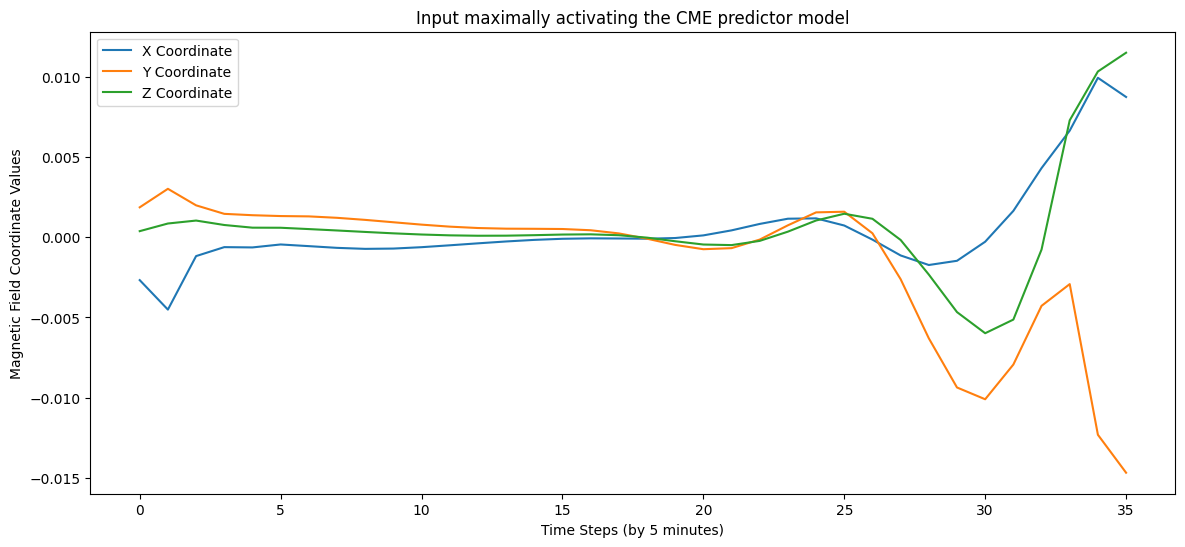

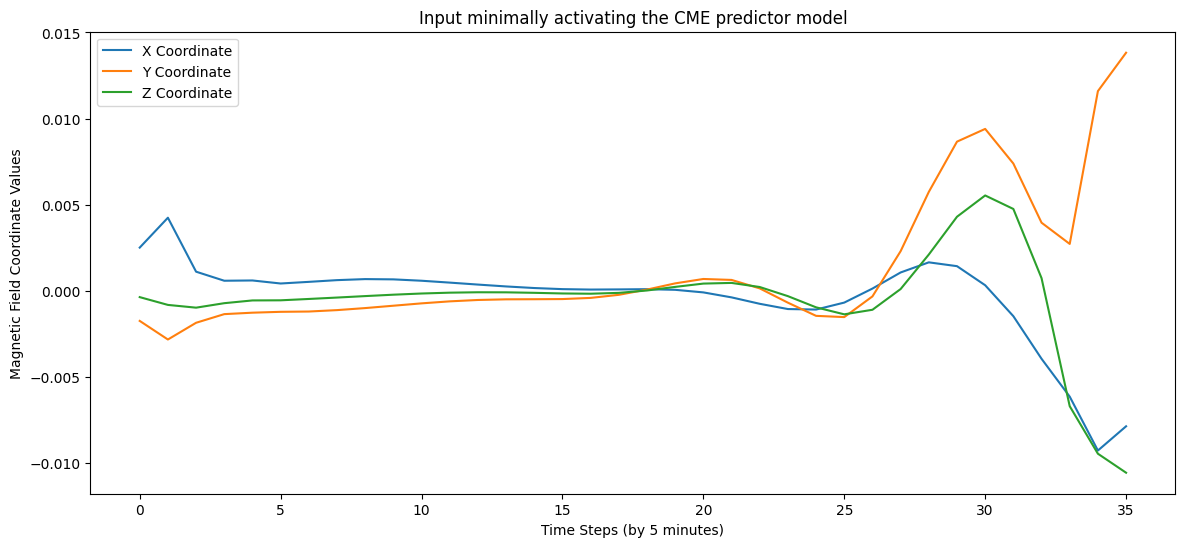

In [81]:
plot_series(optimized_input, opti_type='max')
plot_series(minimized_input, opti_type='min')